In [1]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from pathlib import Path
import dotenv
import json
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'stepnet'
PATH_YANGNET = os.path.join(p_code,net) 
sys.path.insert(0, PATH_YANGNET)

from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance

from tools_lnd import make_h_all, PC_axes, proximate_fp, calc_jacobian_at, get_model_params
from tools_lnd import make_dendro, gen_trials_from_model_dir, gen_X_from_model_dir, get_T_inds
from tools_lnd import get_D, make_h_trial_rule, get_model_params, plot_N, same_stim_trial, remove_spines

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# ##################################################################
# #fig save path
# ##################################################################
fig_name = 'suppfig10'
figpath = os.path.join(p_code,'figs',fig_name,fig_name+'ABCD')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [4]:
rule_set_names = ['DelayPro', 'ReactPro', 'MemoryPro', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'IntegrationModality1', 'IntegrationModality2', 'ContextIntModality1', 'ContextIntModality2', 'IntegrationMultimodal',
              'ReactMatch2Sample', 'ReactNonMatch2Sample', 'ReactCategoryPro', 'ReactCategoryAnti']

rule_trains_all = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

task_name_dict = {}
task_name_dict['Dly Anti'] = rule_set_names[5]
task_name_dict['RT Go'] = rule_set_names[1]
task_name_dict['Dly Go'] = rule_set_names[2]
task_name_dict['RT Anti'] = rule_set_names[4]
task_name_dict['Anti'] = rule_set_names[3]
task_name_dict['Go'] = rule_set_names[0]
task_name_dict['DNMS'] = rule_set_names[12]
task_name_dict['DMS'] = rule_set_names[11]
task_name_dict['DMC'] = rule_set_names[13]
task_name_dict['DNMC'] = rule_set_names[14]
task_name_dict['Dly DM 2'] = rule_set_names[7]
task_name_dict['Dly DM 1'] = rule_set_names[6]
task_name_dict['Ctx Dly DM 2'] = rule_set_names[9]
task_name_dict['Ctx Dly DM 1'] = rule_set_names[8]
task_name_dict['MultSen Dly DM'] = rule_set_names[10]

task_dict = {}
task_dict['Dly Anti'] = rule_trains_all[5]
task_dict['RT Go'] = rule_trains_all[1]
task_dict['Dly Go'] = rule_trains_all[2]
task_dict['RT Anti'] = rule_trains_all[4]
task_dict['Anti'] = rule_trains_all[3]
task_dict['Go'] = rule_trains_all[0]
task_dict['DNMS'] = rule_trains_all[12]
task_dict['DMS'] = rule_trains_all[11]
task_dict['DMC'] = rule_trains_all[13]
task_dict['DNMC'] = rule_trains_all[14]
task_dict['Dly DM 2'] = rule_trains_all[7]
task_dict['Dly DM 1'] = rule_trains_all[6]
task_dict['Ctx Dly DM 2'] = rule_trains_all[9]
task_dict['Ctx Dly DM 1'] = rule_trains_all[8]
task_dict['MultSen Dly DM'] = rule_trains_all[10]

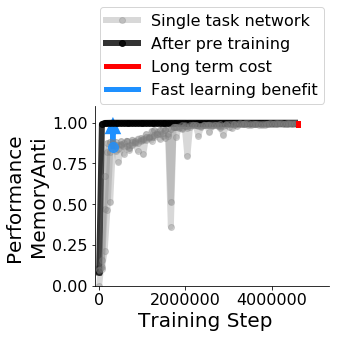

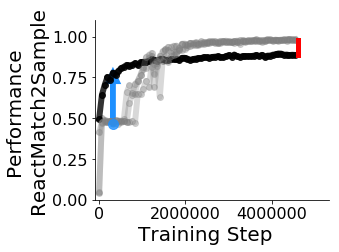

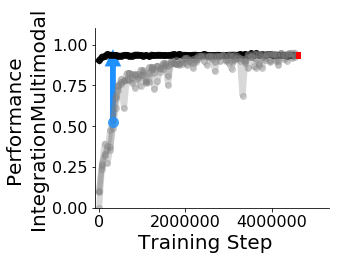

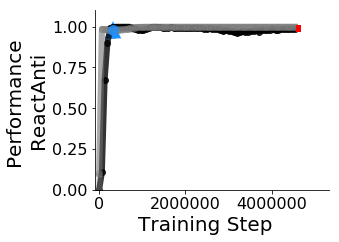

In [63]:
data_folder = 'final1'
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'diag'
seed = '0'
n_rnn = str(128)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -6

# comp_at2 = 640000#10048000#47360000#
comp_at2 = 5*64000#10048000#47360000#
comp_at1 = 4544000+64000#5952000

for pop_rule in [5,11,10,4]:# range(len(rule_trains_all)): #[5,11,8,9,10]: #
    
#     if pop_rule==12:
#         comp_at1 = 7680000
#     else:
#         comp_at1 = 10880000#10240000#7
    
    fig = plt.figure(figsize=(4.2, 3.3))
    plt.rcParams.update({'font.size': 16})
    task_list = ['delayanti',]
    ax_cost = plt.subplot(111)

    rule_trains_pre = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
    'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
    'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

    rule_trains_pre.pop(pop_rule)

    post_train = rule_trains_all[pop_rule]

    s = '_'
    rule_trains_str = s.join(rule_trains_pre)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    post_m = os.path.join(p,'data','rnn','multitask',net,data_folder,
                            rnn_type,activation,init,'leave_one',str(len(rule_trains_pre))+'_tasks',
                            str(n_rnn)+'_n_rnn',net_name,'post_train_'+post_train,seed, 'log.json')
    
    with open(post_m, 'r') as f:
        log_post = json.load(f)
    
    net_name_sing = 'lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_'
    
    for seed_str in ['4','5','6']:
        sing_m = os.path.join(p,'data/rnn/multitask/stepnet/',data_folder,'all',rnn_type,activation,init,'1_tasks',
                              str(n_rnn)+'_n_rnn',net_name_sing+post_train,seed_str, 'log.json')


        with open(sing_m, 'r') as f:
            log_sing = json.load(f)

        plt.sca(ax_cost)
        x = log_sing['perf_'+post_train]
        

        if seed_str=='4':
            plt.plot(log_sing['trials'][:log_sing['trials'].index(comp_at1)],log_sing['perf_'+post_train][:log_sing['trials'].index(comp_at1)],'-o',c ='gray',
                 alpha = .3,linewidth = 6,label = 'Single task network')
            plt.plot(log_post['trials'][:log_sing['trials'].index(comp_at1)],log_post['perf_'+post_train][:log_sing['trials'].index(comp_at1)],'-o',c = 'k',
             alpha = .8,linewidth = 6,label = 'After pre training')
        else:
            plt.plot(log_sing['trials'][:log_sing['trials'].index(comp_at1)],log_sing['perf_'+post_train][:log_sing['trials'].index(comp_at1)],'-o',c ='gray',
                 alpha = .3,linewidth = 6)
    
    ax_cost.set_xlabel('Training Step  ',fontsize = 20)
    ax_cost.set_ylabel('Performance \n'+rule_set_names[pop_rule],fontsize = 20)

    comp_at = comp_at1
    y1 = (log_post['perf_'+post_train])[log_post['trials'].index(comp_at)]
    y2 = (log_sing['perf_'+post_train])[log_sing['trials'].index(comp_at)]
    x = comp_at
    
    plt.plot([comp_at,comp_at],[y1,y2],'-r',linewidth = 5,label = 'Long term cost')
        
    comp_at = comp_at2
    y1 = (log_post['perf_'+post_train])[log_post['trials'].index(comp_at)]
    y2 = (log_sing['perf_'+post_train])[log_sing['trials'].index(comp_at)]
    x = comp_at
    
    plt.plot([comp_at,comp_at],[y1,y1],'-',c = 'dodgerblue',linewidth = 5,label = 'Fast learning benefit')
    plt.arrow(comp_at,y2,0,-y2+y1,color = 'dodgerblue',alpha = 1,linewidth = 5, overhang = 0,
              length_includes_head =True, head_width=200000, head_length=0.055)
    plt.plot(comp_at,y2,'o',color = 'dodgerblue', alpha = .8,markersize = 10)
    
    if pop_rule==5:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6))

    ax_cost.spines['top'].set_visible(False)
    ax_cost.spines['right'].set_visible(False)
    plt.sca(ax_cost)
    plt.ylim(0,1.1)
    plt.xlim(-100000,1.05*comp_at1+500000)

    figname = 'perf_transfer '+post_train
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches = 'tight')


In [64]:
def get_max_corr_epoch(m,epoch = 'go1'):
    cluster_var = np.load(os.path.join(m,'lesion_fps_hierarchical_ward_distance_opt_clust',
                                       'cluster_var.npz'))

    full_corr_mat = np.corrcoef(cluster_var['D'])
    feature_names_master = cluster_var['tick_names']
    len_te = len(feature_names_master)
    feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
    task_binary_True = {}
    task_binary_False = {}
    max_corr = {}
    max_corr_id = {}
    for rule in rule_trains_all:
        
        task_binary_True[rule] = [((feat_name.rsplit(' ', 1)[0] == rule_name[rule]) & (feat_name.rsplit(' ', 1)[-1] == epoch))
                                  for feat_name in feature_names_master]
        task_binary_False[rule] = [((feat_name.rsplit(' ', 1)[0] != rule_name[rule]) & (feat_name.rsplit(' ', 1)[-1] == epoch))
                                   for feat_name in feature_names_master]

        max_corr[rule] = np.zeros(len(np.argwhere(task_binary_True[rule])))
        max_corr_id[rule] = np.zeros(len(np.argwhere(task_binary_True[rule])))
        
        for xi in range(len(np.argwhere(task_binary_True[rule]))):

            max_corr[rule][xi] = np.sort(full_corr_mat[np.argwhere(task_binary_True[rule])[xi][0],
                                                   task_binary_False[rule]])[-1]
            max_corr_id[rule][xi] = np.argsort(full_corr_mat[np.argwhere(task_binary_True[rule])[xi][0],
                                                   task_binary_False[rule]])[-1]
            
    return max_corr, max_corr_id

In [65]:
def get_max_corr_load_mat(mat,feature_names_master,epoch = 'go1'):

    full_corr_mat = mat
    len_te = len(feature_names_master)
    feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
    task_binary_True = {}
    task_binary_False = {}
    max_corr = {}
    max_corr_id = {}
    for rule in rule_trains_all:
        
        task_binary_True[rule] = [((feat_name.rsplit(' ', 1)[0] == rule_name[rule]) & (feat_name.rsplit(' ', 1)[-1] == epoch))
                                  for feat_name in feature_names_master]
        task_binary_False[rule] = [((feat_name.rsplit(' ', 1)[0] != rule_name[rule]) & (feat_name.rsplit(' ', 1)[-1] == epoch))
                                   for feat_name in feature_names_master]

        max_corr[rule] = np.zeros(len(np.argwhere(task_binary_True[rule])))
        max_corr_id[rule] = np.zeros(len(np.argwhere(task_binary_True[rule])))
        
        for xi in range(len(np.argwhere(task_binary_True[rule]))):

            max_corr[rule][xi] = np.sort(full_corr_mat[np.argwhere(task_binary_True[rule])[xi][0],
                                                   task_binary_False[rule]])[-1]
            max_corr_id[rule][xi] = np.argsort(full_corr_mat[np.argwhere(task_binary_True[rule])[xi][0],
                                                   task_binary_False[rule]])[-1]
            
    return max_corr, max_corr_id

In [66]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names']

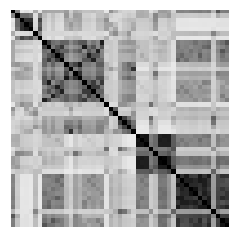

In [67]:
#MAKE COR MATS
# set of networks to compare

seed_set = [str(0),str(1),str(2)]#[str(0),str(1)]

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

n_tasks = str(len(rule_trains))
n_rnn = 128
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = 1
lr = -6
sigma_rec = 1/20
sigma_x = 2/20
pop_rule = 5
ruleset = 'all'
w_rec_coeff  = 8/10

import matplotlib.patches as patches
rnn_type_set = ['LeakyGRU','LeakyRNN']
activation_set = ['tanh','retanh','softplus']
w_init_set = ['diag','randgauss']
data_folder_set = ['final1', ]# 

# rnn_type_set = ['LeakyRNN',]
# activation_set = ['softplus',]
# w_init_set = ['diag',]
    
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyGRU/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w0.0_h0.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0'
method = 'ward'
criterion = 'distance'
cel_max_d = '3.5'
lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(cel_max_d)
corr_mat_stack = []
for rnn_type_i in range(len(rnn_type_set)):
    for activation_i in range(len(activation_set)):
        for w_init_i in range(len(w_init_set)):
            for data_folder in data_folder_set:
            
                rnn_type = rnn_type_set[rnn_type_i]
                activation = activation_set[activation_i]
                w_init = w_init_set[w_init_i]

                for seed in seed_set:
                    
                    if data_folder=='no_noise':
                        l2w = -0
                        l2h = -0
                    else:
                        l2w = -6
                        l2h = -6
                        
                    if (rnn_type == 'LeakyRNN') & (activation == 'tanh') & (data_folder == 'final1'):
                        w_rec_coeff  = 1
                        lr = -8
                    else:
                        w_rec_coeff  = 8/10
                        lr = -6
                        
                    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

                    net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

                    m = os.path.join(p,'data','rnn','multitask','stepnet',data_folder,ruleset,
                                            rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                                            str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))
                    #load atlas data
                    save_dir = os.path.join(m,lesion_folder)
                    cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
                    D = cluster_var['D'].T
                    feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]

                    feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
                    X = D[:,feat_order]

                    corr_mat = np.corrcoef(X.T)
                    
                    if len(corr_mat_stack)==0:
                        corr_mat_stack = corr_mat[:,np.newaxis]
                    else:
                        corr_mat_stack = np.concatenate((corr_mat_stack,corr_mat[:,np.newaxis]),axis=1)

corr_mat_ave = np.mean(corr_mat_stack,axis = 1)

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)
plt.imshow(corr_mat_ave,cmap= 'Greys',clim = (-.5,1))
remove_spines(ax)
ax.set_yticks([])
ax.set_xticks([])

figname = 'all_net_corr.pdf'
full_figpath = os.path.join(figpath,'corr_mats_nolabels')
if not os.path.exists(full_figpath):
    os.makedirs(full_figpath)
plt.savefig(os.path.join(full_figpath,figname))
plt.show()

In [68]:
task = 'contextdelaydm2'
ind = [tasks[x]==task for x in range(len(tasks))]
ind_args = np.argwhere(ind)
ind_not = [tasks[x] != task for x in range(len(tasks))]
not_task_corr = corr_mat_ave[:,ind_not]

max_period_cors = []
for ind_i in ind_args:
    max_period_cors.append(np.sort(not_task_corr[ind_i,:],axis = 1)[0][-1])
    print(feature_names_master[ind_i],feature_names_master[np.argsort(not_task_corr[ind_i,:],axis = 1)[0][-1]])

max_period_cors

NameError: name 'tasks' is not defined

In [69]:
feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
task_labels = [task_name_dict[feat] for feat in feature_names_labels]
tasks = [task_dict[feat] for feat in feature_names_labels]

sharable_index = {}
unique_index = {}
for task in np.unique(tasks):
    ind = [tasks[x]==task for x in range(len(tasks))]
    ind_args = np.argwhere(ind)
    ind_not = [tasks[x] != task for x in range(len(tasks))]
    not_task_corr = corr_mat_ave[:,ind_not]
    
    max_period_cors = []
    for ind_i in ind_args:
        max_period_cors.append(np.sort(not_task_corr[ind_i,:],axis = 1)[0][-1])
        
    sharable_index[task] = np.max(max_period_cors)
    unique_index[task] = np.min(max_period_cors)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdgo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactgo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaygo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaydm1:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<t

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdgo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactgo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaygo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaydm1:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<t

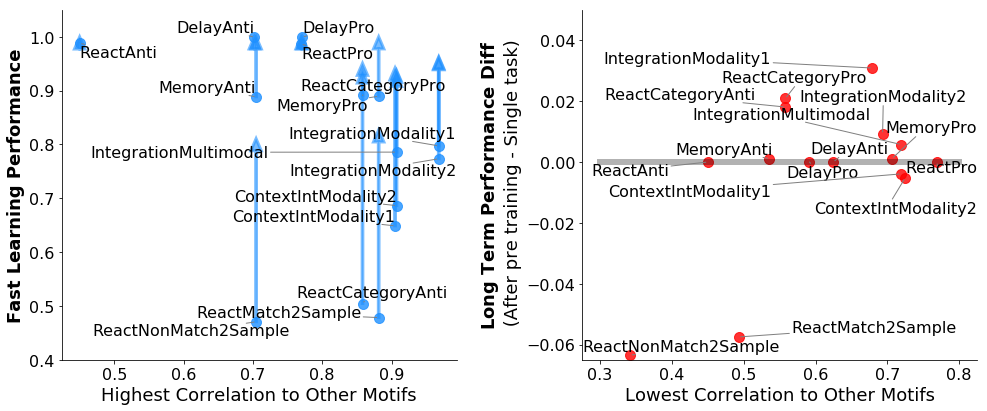

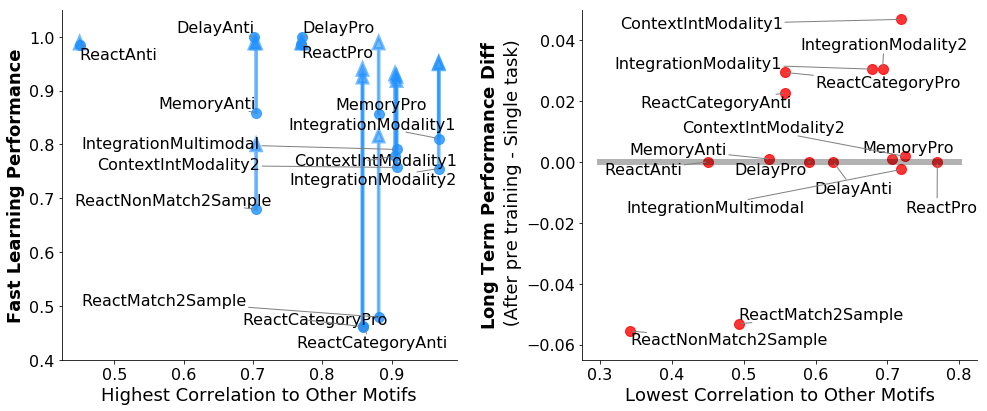

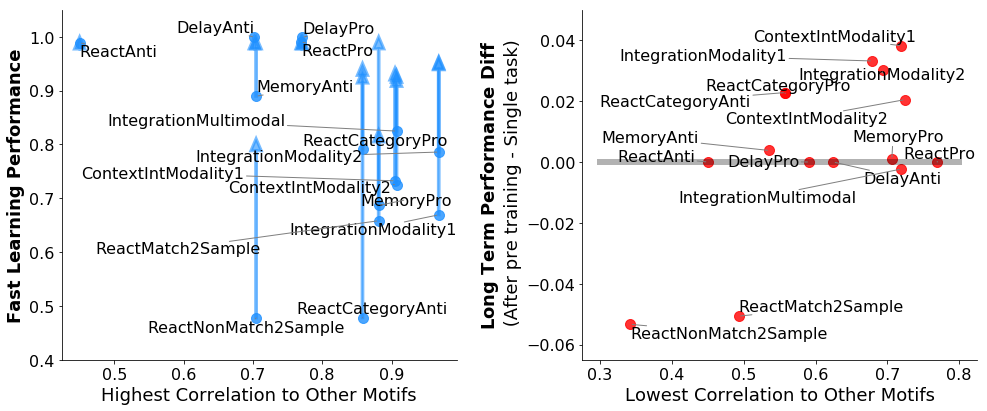

In [71]:
from adjustText import adjust_text
data_folder = 'final1'
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'diag'
seed = '0'
n_rnn = str(128)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -6
net_name_sing = 'lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_'

max_corr, max_corr_id = get_max_corr_load_mat(corr_mat_ave,feature_names_master,epoch = 'go1')

comp_at2 = 640000

for seed_int in range(4,7):
        
    fig = plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(122)
    ax2 = plt.subplot(121)

    seed_str = str(seed_int)
    
    diff_perf = {}
    learn_ben_perf = {}
    together1 = []
    together2 = []

    for pop_rule in range(len(rule_trains_all)):
        
        post_train = rule_trains_all[pop_rule]

        sing_m = os.path.join(p,'data/rnn/multitask/stepnet/',data_folder,'all',rnn_type,activation,init,'1_tasks',
                              str(n_rnn)+'_n_rnn',net_name_sing+post_train,seed_str)
        
        rule_trains_pre = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
                           'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
                           'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

        rule_trains_pre.pop(pop_rule)

        s = '_'
        rule_trains_str = s.join(rule_trains_pre)

        net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
        post_m = os.path.join(p,'data','rnn','multitask',net,data_folder,
                                rnn_type,activation,init,'leave_one',str(len(rule_trains_pre))+'_tasks',
                                str(n_rnn)+'_n_rnn',net_name,'post_train_'+post_train,seed)

        model = Model(post_m)
        with open(post_m+ '/log.json', 'r') as f:
            log_post = json.load(f)
            perf_post = (log_post['perf_'+post_train])
        
        with open(sing_m+ '/log.json', 'r') as f:
            log_sing = json.load(f)
            perf_sing = (log_sing['perf_'+post_train])

        diff_perf[post_train] = np.max(perf_post)-np.max(perf_sing)
        learn_ben_perf[post_train] = [perf_post[log_post['trials'].index(comp_at2)],perf_sing[log_sing['trials'].index(comp_at2)]] 

        sharability = [sharable_index[post_train],sharable_index[post_train]] 
        uniqueness = [unique_index[post_train],unique_index[post_train]]                       

#             ax1.plot(sharability,diff_perf[post_train],'-r',label = post_train, alpha = .8,markersize = 10)
        plt.arrow(sharability[0],learn_ben_perf[post_train][1],0,-learn_ben_perf[post_train][1]+learn_ben_perf[post_train][0],
                  color = 'dodgerblue',alpha = .6,linewidth = 3, overhang = 0, head_width = .015, length_includes_head =True)

        ax1.plot(uniqueness[0],diff_perf[post_train],'or',label = post_train, alpha = .8,markersize = 10)
        ax2.plot(sharability[0],learn_ben_perf[post_train][1],'o',c = 'dodgerblue',label = post_train, alpha = .8,markersize = 10)

        together1.append((unique_index[post_train],diff_perf[post_train],rule_set_names[pop_rule],'k'))
        together2.append((sharable_index[post_train],learn_ben_perf[post_train][1],rule_set_names[pop_rule],'k'))

    plt.axes(ax2)
    plt.ylim([.4,1.05])
    texts = []
    for x, y, s, c in together2:
        texts.append(ax2.text(x, y, s, color = c, fontsize = 16))
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="-", color='gray', lw=1))
    plt.ylabel('Fast Learning Performance',fontsize = 18, weight="bold")
    plt.xlabel('Highest Correlation to Other Motifs',fontsize = 18)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    plt.axes(ax1)
    plt.ylim([-.065,.05])
    plt.plot([.3,.8],[0,0],'-k',alpha = .3,linewidth = 6)
    texts = []
    for x, y, s, c in together1:
        texts.append(ax1.text(x, y, s, color = c, fontsize = 16))
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="-", color='gray', lw=1))

    plt.ylabel(r"$\bf{Long \ Term \ Performance \ Diff}$"+' \n (After pre training - Single task)',fontsize = 18)
    plt.xlabel('Lowest Correlation to Other Motifs',fontsize = 18)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    fig.tight_layout()

    figname = 'perf_sharability_transfer_success_'+seed_str
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches = 'tight')
    # plt.savefig(os.path.join(figpath,figname+'.png'),bbox_inches = 'tight')


In [13]:
post_train = 'reactanti'
print(sharable_index[post_train],unique_index[post_train])

0.44994293938294505 0.44994293938294505


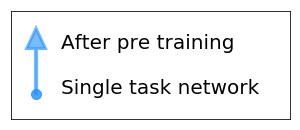

In [12]:
fig = plt.figure(figsize=(5, 2))
ax1 = plt.subplot(111)
plt.arrow(sharability[0],learn_ben_perf[post_train][1],0,.05,
          color = 'dodgerblue',alpha = .6,linewidth = 3, overhang = 0, head_width = .015)
ax1.plot(sharability[0],learn_ben_perf[post_train][1],'o',c = 'dodgerblue',label = post_train, alpha = .8,markersize = 10)


plt.text(sharability[0]+.02,learn_ben_perf[post_train][1]+.05,'After pre training',fontsize = 20)
plt.text(sharability[0]+.02,learn_ben_perf[post_train][1],'Single task network',fontsize = 20)
ax1.set_ylim([.45,.57])
ax1.set_xlim([sharability[0]-.02,sharability[0]+.2])
ax1.set_xticks([])
ax1.set_yticks([])


figname = 'perf_sharability_transfer_success_legend'
plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches = 'tight')
    
plt.show()
